In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets,transforms
from torch.utils.data import DataLoader
import random
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score,recall_score


In [2]:
train = datasets.MNIST(
    root = (r"C:\Users\rohit\Desktop\machine learning\Datasets"),
    train = True,
    download = True,
    transform = torchvision.transforms.ToTensor(),
    target_transform = None
    )

In [3]:
test = datasets.MNIST(
    root = (r"C:\Users\rohit\Desktop\machine learning\Datasets"),
    train = False,
    download = True,
    transform = torchvision.transforms.ToTensor(),
    target_transform = None
    )

In [4]:
test

Dataset MNIST
    Number of datapoints: 10000
    Root location: C:\Users\rohit\Desktop\machine learning\Datasets
    Split: Test
    StandardTransform
Transform: ToTensor()

In [5]:
train

Dataset MNIST
    Number of datapoints: 60000
    Root location: C:\Users\rohit\Desktop\machine learning\Datasets
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
len(train) , len(test)

(60000, 10000)

In [7]:
train[0][0].shape

torch.Size([1, 28, 28])

In [8]:
classes = train.classes
classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

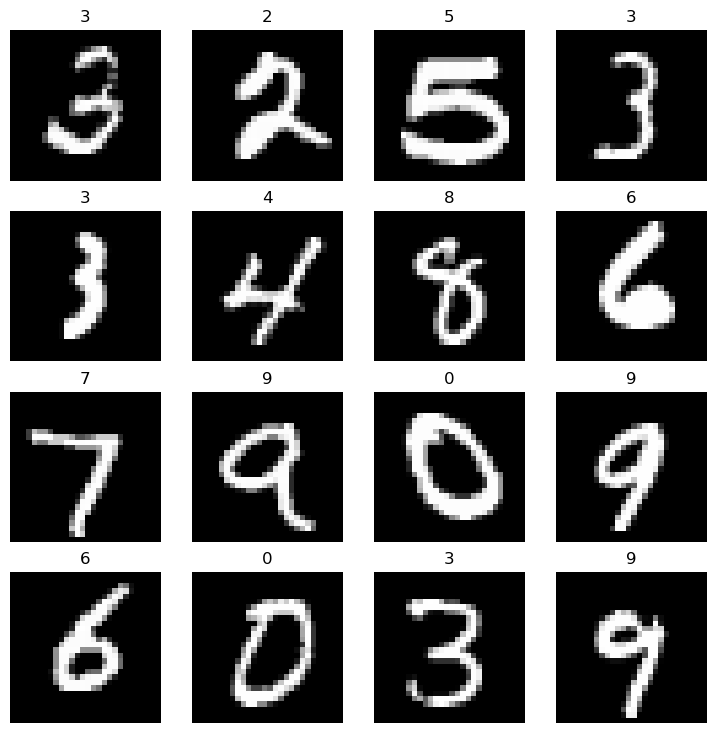

In [9]:
fig = plt.figure(figsize=(9,9))
row = 4
col = 4
for i in range(1,(row*col)+1):
    ran = random.randint(0,len(train))
    img,target = train[ran]
    fig.add_subplot(row,col,i)
    plt.imshow(img.squeeze(),cmap="gray")
    plt.axis(False)
    plt.title(train[ran][1])
    

In [10]:
train_load = DataLoader(train,32,shuffle=True)
test_load = DataLoader(test,32,shuffle=True)

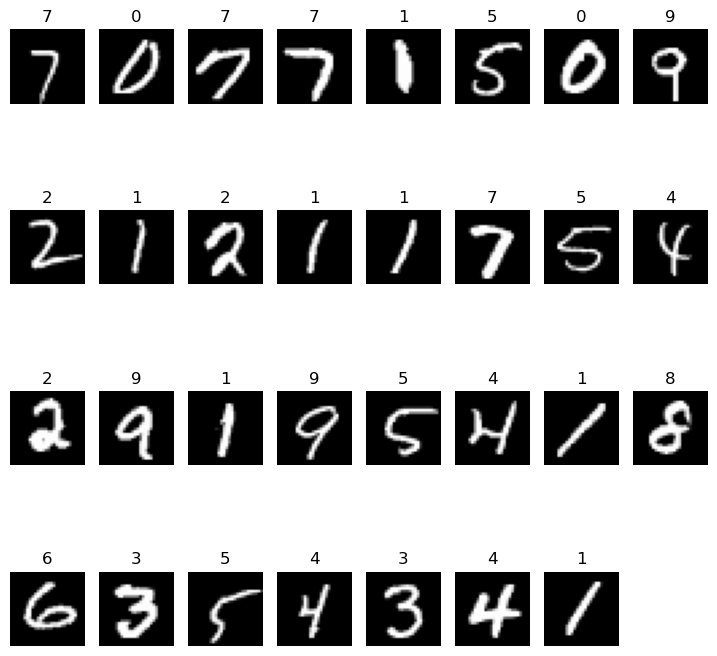

In [11]:
#batch visualisation
fig = plt.figure(figsize=(9,9))
row = 4
col = 8
a,b = next(iter(train_load))
for i in range(1,len(a)):
    ran = i
    img = a[ran]
    target = (b[ran]).item()
    fig.add_subplot(row,col,i)
    plt.imshow(img.squeeze(),cmap="gray")
    plt.axis(False)
    plt.title(target)


# Model

In [12]:
class mnistcv(nn.Module):
    def __init__(self):
        super().__init__()
        self.seq= nn.Sequential(nn.Flatten(),
                  nn.Linear(784,1500),
                  nn.ReLU(),
                  nn.Linear(1500,10)
        )

    def forward(self,x):
        return self.seq(x)

In [13]:
%%time
epoch = 3
lr = 0.03
model = mnistcv()
optimizer = torch.optim.SGD(model.parameters(),lr=lr)
loss = nn.CrossEntropyLoss()
for i in tqdm(range(epoch-1)):
    model.train()
    tot_cost = 0
    for batch,(x,y) in enumerate(train_load):
        logit = model(x)
        cost = loss(logit,y)
        tot_cost += cost
        pred = torch.softmax(logit,dim=1).argmax(dim=1)
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        if(batch%300)==0:
            print(f"BATCH : {batch} ")
    model.eval()
    with torch.inference_mode():
        test_acc = 0
        test_cost = 0
        for X,Y in test_load:
            pred = model(X)
            cost = loss(pred,Y)
            acc = accuracy_score(Y,pred.argmax(dim=1))
            test_acc += acc
            test_cost += cost
        test_cost = test_cost/len(test_load)
        test_acc = test_acc/len(test_load)
        print(f"TRAIN COST = {tot_cost/len(train_load)}  TEST COST : {test_cost}  ACCURACY : {test_acc}")
    
    
        
        

  0%|          | 0/2 [00:00<?, ?it/s]

BATCH : 0 
BATCH : 300 
BATCH : 600 
BATCH : 900 
BATCH : 1200 
BATCH : 1500 
BATCH : 1800 
TRAIN COST = 0.48079878091812134  TEST COST : 0.27400922775268555  ACCURACY : 0.9234225239616614
BATCH : 0 
BATCH : 300 
BATCH : 600 
BATCH : 900 
BATCH : 1200 
BATCH : 1500 
BATCH : 1800 
TRAIN COST = 0.25309741497039795  TEST COST : 0.2107519805431366  ACCURACY : 0.9402955271565495
CPU times: total: 2min 3s
Wall time: 18.7 s


# CNN MODEL

In [14]:
class imagem(nn.Module):
    def __init__(self,input_size:int,hidden_size:int,output_size:int):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels = input_size,
                      out_channels = hidden_size,
                      kernel_size = (3,3),
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (2,2))
        )
     
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels = hidden_size,
                      out_channels = hidden_size,
                      kernel_size = (3,3),
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (2,2))
        )
        self.conn = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = hidden_size*5*5,
                      out_features = output_size),
            nn.ReLU(),
        )

    def forward(self,x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.conn(x)
        return x
        

            

In [18]:
epoch = 1
lr = 0.03
model = imagem(1,15,10)
optimizer = torch.optim.SGD(model.parameters(),lr = lr)
loss = nn.CrossEntropyLoss()


In [19]:
for i in tqdm(range(epoch)):
    train_loss = 0
    test_accuracy =0 
    test_loss = 0

    for batch,(x,y) in enumerate(train_load):
        logit = model(x)
        cost = loss(logit,y)
        train_loss +=cost
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        
    for batch,(x,y) in enumerate(test_load):
        logit = model(x)
        cost = loss(logit,y)
        test_loss += cost
        acc = accuracy_score(y,logit.argmax(dim=1))
        acc = acc*100
        test_accuracy += acc
        
        
    train_loss = train_loss/len(train_load)
    test_loss = test_loss/len(test_load)
    test_accuracy = test_accuracy/len(test_load)
    print(f"COST PER EPOCH : {train_loss}   TEST LOSS : {test_loss}  TEST ACCURACY : {test_accuracy}")

  0%|          | 0/1 [00:00<?, ?it/s]

COST PER EPOCH : 0.52596515417099   TEST LOSS : 0.14685069024562836  TEST ACCURACY : 95.7667731629393


In [20]:
for batch,(x,y) in enumerate(train_load):
    print(y)
    break
    

tensor([6, 4, 1, 4, 4, 6, 2, 7, 0, 1, 8, 9, 3, 2, 8, 9, 3, 8, 5, 7, 0, 0, 3, 0,
        3, 1, 2, 3, 2, 8, 7, 4])


In [22]:
x.shape

torch.Size([32, 1, 28, 28])